<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/GIT/Fine_tune_GIT_on_an_image_captioning_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tune GIT on a custom dataset for image captioning

In this notebook, we'll fine-tune [GIT](https://huggingface.co/docs/transformers/main/en/model_doc/git), short for GenerativeImage2Text, on a toy image captioning dataset.

GIT is, at the moment of writing, a state-of-the-art image/video captioning and question answering (QA) model.

## Set-up environment

First, let's install 🤗 Transformers as well as 🤗 Datasets.

In [3]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [4]:
!pip install -q datasets

## Create image captioning dataset

Next, we'll create a tiny image captioning dataset, which as you might have guessed consists of (image, text) pairs.

As I'm a football fan I simply went to the Wikipedia page of a few of the most famous footballers, and took a captioned image from their respective pages.

We'll follow the guide [here](https://huggingface.co/docs/datasets/main/en/image_dataset#image-captioning) to create a 🤗 Dataset, which allows for very fast processing. Basically, we need to add a metadata.jsonl file to our folder containing the images. This metadata file contains the captions, for each of the images.

In [1]:
import json

captions = [{"file_name": "ronaldo.jpeg", "text": "Ronaldo with Portugal at the 2018 World Cup"},
{"file_name": "messi.jpeg", "text": "Messi with Argentina at the 2022 FIFA World Cup"},
{"file_name": "zidane.jpeg", "text": "Zinédine Zidane pendant la finale de la Coupe du monde 2006."},
{"file_name": "maradona.jpeg", "text": "Maradona after winning the 1986 FIFA World Cup with Argentina"},
{"file_name": "ronaldo_.jpeg", "text": "Ronaldo won La Liga in his first season and received the Pichichi Trophy in his second."},
{"file_name": "pirlo.jpeg", "text": "Pirlo with Juventus in 2014"},]

# path to the folder containing the images
root = "/content/drive/MyDrive/GenerativeImage2Text/Tutorial notebooks/Toy_dataset/"

# add metadata.jsonl file to this folder
with open(root + "metadata.jsonl", 'w') as f:
    for item in captions:
        f.write(json.dumps(item) + "\n")

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/GenerativeImage2Text/Tutorial notebooks/Toy_dataset/metadata.jsonl'

Next, we use the [ImageFolder](https://huggingface.co/docs/datasets/main/en/image_dataset#imagefolder) feature to quickly turn this into a 🤗 Dataset. We'll specify that this is just the training split of the dataset.

In [29]:
from datasets import load_dataset 

#dataset = load_dataset("imagefolder", data_dir=root, split="train")
dataset = load_dataset("soul11zz/image-caption-desc-only", split="train")

Using custom data configuration soul11zz--image-caption-desc-only-ea22350b1965e317
Found cached dataset parquet (C:/Users/berno/.cache/huggingface/datasets/soul11zz___parquet/soul11zz--image-caption-desc-only-ea22350b1965e317/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


Let's check whether the dataset is created correctly:

In [30]:
dataset

Dataset({
    features: ['image', 'text'],
    num_rows: 13066
})

Let's take a look at one example:

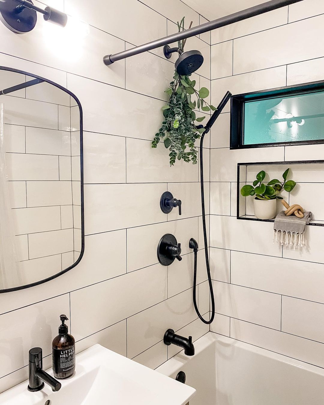

In [31]:
example = dataset[0]
image = example["image"]
width, height = image.size
image.resize((int(0.3*width), int(0.3*height)))


Let's check its corresponding caption:

In [32]:
example["text"]

'Shower Niche with Black Schluter Trim'

## Create PyTorch Dataset

Next, we create a standard [PyTorch dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html). Each item of the dataset returns the expected inputs for the model, in this case input_ids, attention_mask and pixel_values. 

We use `GitProcessor` to turn each (image, text) pair into the expected inputs. Basically, the text gets turned into `input_ids` and `attention_mask`, and the image gets turned into `pixel_values`.

In [33]:
from torch.utils.data import Dataset

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]

        encoding = self.processor(images=item["image"], text=item["text"], padding="max_length", return_tensors="pt")

        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}

        return encoding

In [34]:
from transformers import GitProcessor

processor = GitProcessor.from_pretrained("microsoft/git-base")

In [35]:
train_dataset = ImageCaptioningDataset(dataset, processor)

Let's check one example of the dataset:

In [36]:
item = train_dataset[0]
for k,v in item.items():
  print(k,v.shape)

input_ids torch.Size([512])
attention_mask torch.Size([512])
pixel_values torch.Size([3, 224, 224])


## Create PyTorch DataLoader

Next, we create a corresponding [PyTorch DataLoader](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html), which allows us to get batches of data from the dataset.

We need this as neural networks (like GIT) are trained on batches of data, using stochastic gradient descent (SGD).

In [37]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=2)

In [38]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

input_ids torch.Size([2, 512])
attention_mask torch.Size([2, 512])
pixel_values torch.Size([2, 3, 224, 224])


Let's check one batch, and do some sanity checks. We can decode the input_ids back into text for instance:

In [22]:
processor.decode(batch["input_ids"][0])

'[CLS] a simple landscape in a modern living room [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [P

We can "denormalize" the pixel values to get back an image:

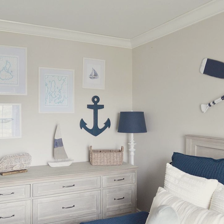

In [39]:
from PIL import Image
import numpy as np

MEAN = np.array([123.675, 116.280, 103.530]) / 255
STD = np.array([58.395, 57.120, 57.375]) / 255

unnormalized_image = (batch["pixel_values"][0].numpy() * np.array(STD)[:, None, None]) + np.array(MEAN)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(unnormalized_image)

Looks ok! Always important to check your data ;) see [this blog](http://karpathy.github.io/2019/04/25/recipe/) for a great overview of tips when training neural networks.

## Define model

Next, we instantiate a model. We start from the pre-trained GIT-base model (which was already pre-trained on 4 million image-text pairs by Microsoft).

Of course, feel free to start fine-tuning another GIT model from the [hub](https://huggingface.co/models?other=git).

In [40]:
from transformers import AutoModelForCausalLM, GitForCausalLM

model = GitForCausalLM.from_pretrained("microsoft/git-base")

In [8]:
f"{model.num_parameters() :,}"

'176,619,066'

## Dummy forward pass

It's always good to check the initial loss on a batch. See also the blog above.

In [42]:
outputs = model(input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                pixel_values=batch["pixel_values"],
                labels=batch["input_ids"])
outputs.loss()

odict_keys(['loss', 'logits'])

## Train the model

Next, let's train the model! We use native PyTorch here.

As I created a super tiny dataset just for demo purposes, we'll let the model overfit it. If it's capable of overfitting it (i.e. achieve zero loss), then that's a great way to know that everything is working properly. See also the blog above.

In [26]:
import torch

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()

for epoch in range(1):
  print("Epoch:", epoch)
  for idx, batch in enumerate(train_dataloader):
    input_ids = batch.pop("input_ids").to(device)
    pixel_values = batch.pop("pixel_values").to(device)

    outputs = model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    labels=input_ids)
    
    loss = outputs.loss

    print("Loss:", loss.item())

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

Epoch: 0
Loss: 12.726551055908203
Loss: 11.050105094909668
Loss: 10.206806182861328
Loss: 9.932334899902344
Loss: 9.69803524017334
Loss: 9.471297264099121
Loss: 9.258853912353516
Loss: 9.07564926147461
Loss: 8.903639793395996
Loss: 8.736238479614258
Loss: 8.621188163757324
Loss: 8.523810386657715
Loss: 8.408945083618164
Loss: 8.268926620483398
Loss: 8.176051139831543
Loss: 8.051152229309082
Loss: 7.926438331604004
Loss: 7.841065883636475
Loss: 7.7406840324401855
Loss: 7.644570827484131
Loss: 7.526823997497559
Loss: 7.473756313323975
Loss: 7.351784706115723
Loss: 7.230169296264648
Loss: 7.138193607330322
Loss: 7.0379109382629395
Loss: 6.933273792266846
Loss: 6.838422775268555
Loss: 6.71588659286499
Loss: 6.606952667236328
Loss: 6.513167858123779
Loss: 6.398482799530029
Loss: 6.302698612213135
Loss: 6.233169078826904
Loss: 6.097189903259277
Loss: 5.997288703918457
Loss: 5.892465591430664
Loss: 5.780638694763184
Loss: 5.668027877807617
Loss: 5.551086902618408
Loss: 5.424737453460693
Loss:

KeyboardInterrupt: 

## Inference

Now that we've trained the model, let's load the Maradona image and perform inference on it.

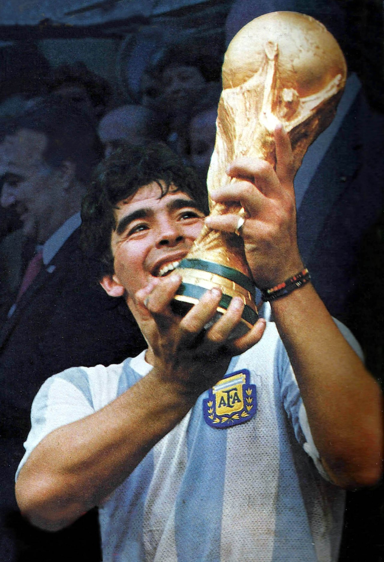

In [21]:
# load image
example = dataset[0]
image = example["image"]
width, height = image.size
display(image.resize((int(0.3*width), int(0.3*height))))

In [22]:
# prepare image for the model
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

maradona after winning the 1986 fifa world cup with argentina


Great! We've successfully fine-tuned GIT on our tiny (image, text) dataset to generate captions of images of football players.